# Evolution

Compute random graphs and statistics from multiple tournesol datasets of different dates to compare them

## 1. Init or update Tournesol dataset (Todo once every week)

- Download zip from https://api.tournesol.app/exports/all/
- Extract zip
	- Recommended to do so in directories names with the week date like: `tournesol_dataset_2023-12-31/`

## 2. Init or update Youtube cache (if tournesol dataset was updated)

Run script `py src/rndstats.py (-t <latest TOURNESOL_DATASET_PATH>) (-c <YTDATA_CACHE_PATH>) --fetch`

## 3. Check and update Notebook variables

See bloc [2] below

In [1]:
# Imports
import os
import re
import matplotlib.dates as mtdt
import html
import plotly.graph_objects as go
import colorsys
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime
from matplotlib.ticker import ScalarFormatter
from numpy import std
from typing import Iterable, Iterator
from matplotlib.axis import Axis
from matplotlib.figure import Figure
from matplotlib.sankey import Sankey
from IPython.display import SVG

# Project imports
sys.path.insert(1, '../src')
from model.youtube_api import YTData
from model.comparisons import ComparisonFile, ComparisonLine
from model.collectivecriteriascores import CollectiveCriteriaScoresFile
from model.individualcriteriascores import IndividualCriteriaScoresFile


In [2]:
# Notebook Variables
TOURNESOL_DATASETS_PARENT_PATH='../data' # Expecting data files located into: <TOURNESOL_DATASETS_PARENT_PATH>/<TOURNESOL_DATASET_PATH_FORMAT>/*.csv
TOURNESOL_DATASET_PATH_FORMAT=r'tournesol_dataset_([0-9]{4}-[0-9]{2}-[0-9]{2})' # SHOULD END in "yyyy-mm-dd"
YTDATA_CACHE_PATH='../data/YTData_cache.json'

In [3]:
# Constants
TOURNESOL_DATASET_PATHS: dict[str, str]={} # date: path
for f in os.listdir(TOURNESOL_DATASETS_PARENT_PATH):
	match = re.match(TOURNESOL_DATASET_PATH_FORMAT, f)
	if match:
		TOURNESOL_DATASET_PATHS[match.group(1)] = os.path.abspath(TOURNESOL_DATASETS_PARENT_PATH+'/'+f)
DATE_MAP = {s: datetime.strptime(s, '%Y-%m-%d').date() for s in TOURNESOL_DATASET_PATHS}
SORTED_DATES = sorted((k,v) for (k,v) in DATE_MAP.items())
LAST = SORTED_DATES[-1][0]
print(TOURNESOL_DATASET_PATHS)

# Data files
COMPARISONS:dict[str,ComparisonFile] = dict()
COLLECTIVE_SCORES:dict[str,CollectiveCriteriaScoresFile] = dict()
INDIVIDUAL_SCORES:dict[str,IndividualCriteriaScoresFile] = dict()
for date in TOURNESOL_DATASET_PATHS:
	COMPARISONS[date] = ComparisonFile(TOURNESOL_DATASET_PATHS[date])
	COLLECTIVE_SCORES[date] = CollectiveCriteriaScoresFile(TOURNESOL_DATASET_PATHS[date])
	INDIVIDUAL_SCORES[date] = IndividualCriteriaScoresFile(TOURNESOL_DATASET_PATHS[date])

# Youtube Data
YTDATA = YTData()
try:
	YTDATA.load(YTDATA_CACHE_PATH)
except FileNotFoundError as e:
	pass

{'2023-09-18': '/home/Nathael.Nogues/Documents/NatNgs/Tournesol-Stats/data/tournesol_dataset_2023-09-18', '2023-07-31': '/home/Nathael.Nogues/Documents/NatNgs/Tournesol-Stats/data/tournesol_dataset_2023-07-31', '2023-10-09': '/home/Nathael.Nogues/Documents/NatNgs/Tournesol-Stats/data/tournesol_dataset_2023-10-09', '2023-06-19': '/home/Nathael.Nogues/Documents/NatNgs/Tournesol-Stats/data/tournesol_dataset_2023-06-19', '2023-06-12': '/home/Nathael.Nogues/Documents/NatNgs/Tournesol-Stats/data/tournesol_dataset_2023-06-12', '2023-09-04': '/home/Nathael.Nogues/Documents/NatNgs/Tournesol-Stats/data/tournesol_dataset_2023-09-04', '2023-07-03': '/home/Nathael.Nogues/Documents/NatNgs/Tournesol-Stats/data/tournesol_dataset_2023-07-03', '2023-06-05': '/home/Nathael.Nogues/Documents/NatNgs/Tournesol-Stats/data/tournesol_dataset_2023-06-05', '2023-10-16': '/home/Nathael.Nogues/Documents/NatNgs/Tournesol-Stats/data/tournesol_dataset_2023-10-16', '2023-09-25': '/home/Nathael.Nogues/Documents/NatNgs/T

<svg viewBox="-100 -100 200 200" xmlns="http://www.w3.org/2000/svg"><g stroke="black" stroke-width="0.1"><line x1="-100" y1="0" x2="100" y2="0"/><line x1="0" y1="-100" x2="0" y2="100"/></g><g font-size="1"><text x="-99" y="1">Collective -100</text><text x="99" y="-1" text-anchor="end">+100 Collective</text><text x="1" y="-99">+100 NatNgs</text><text x="-1" y="99" text-anchor="end">NatNgs -100</text></g><g font-size="1" repeatCount="1"><text x="9.55" y="54.84">_05BBIzfja4<animate attributeName="x" dur="36s" values="-13.53;-13.62;-13.1;-13.09;-13.31;-12.85;-13.63;9;9.07;9.16;9.21;9.57;9.6;9.59;9.59;9.6;9.59;9.54;9.55" keyTimes="0;0.06;0.11;0.17;0.22;0.28;0.33;0.39;0.44;0.5;0.56;0.61;0.67;0.72;0.78;0.83;0.89;0.94"/><animate attributeName="y" dur="36s" values="87.84;88.01;87.07;87.1;87.37;87.07;87.92;57.7;57.23;56.34;55.85;55.54;55.35;55.28;55.19;55.11;54.99;54.92;54.84" keyTimes="0;0.06;0.11;0.17;0.22;0.28;0.33;0.39;0.44;0.5;0.56;0.61;0.67;0.72;0.78;0.83;0.89;0.94"/></text><text x="-2.79"

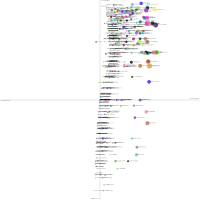

In [5]:
## User against global scores

USER='NatNgs'
CRITERION='largely_recommended'
MIN_DATE = '2023-07-01'

vids:dict[str,dict[str,tuple[float,float,int]]] = dict() # vids[vid][date] = (glob_score, personnal_score, nb_users)

for d in INDIVIDUAL_SCORES:
	indiv = INDIVIDUAL_SCORES[d].get_scores(criterion=CRITERION, users=[USER])[USER] # `(score, uncertainty) = out[video][criterion]`
	glob = COLLECTIVE_SCORES[d].get_scores(criterion=CRITERION, vids=indiv.keys()) # `(score, uncertainty) = out[video][criterion]`
	for vid in indiv:
		vids.setdefault(vid, dict()).setdefault(d, (indiv[vid][CRITERION][0], glob[vid][CRITERION][0], None))

for d in INDIVIDUAL_SCORES:
	scores = INDIVIDUAL_SCORES[d].get_scores(criterion=CRITERION, vids=vids.keys()) # `(score, uncertainty) = out[user][video][criterion]`
	for vid in vids:
		if d in vids[vid]:
			vids[vid][d] = (vids[vid][d][0], vids[vid][d][1], len([u for u in scores if vid in scores[u]]))

# print(vids)

anim_dates = [d[0] for d in SORTED_DATES if d[0] >= MIN_DATE]

step_duration = 2.0 # seconds
steps_count = len(anim_dates)-1
anim_duration = f"{steps_count*step_duration:0.0f}s"
keyTimes = [i/steps_count for i in range(steps_count)]

def make_svg_point(vid:str):
	tt = list(keyTimes)
	xx = []
	yy = []
	rr = []
	for d in anim_dates:
		(y,x,r) = vids[vid].get(d,(0,0,0))
		xx.append(x)
		yy.append(-y)
		rr.append(r)
	
	rr = [math.log10(r+1) for r in rr]

	fill=f"{hash(vid) % (1<<24):6X}"
	animx = \
		  f"dur=\"{anim_duration}\" " \
		+ f"values=\"{';'.join(f'{x:0.2f}'.rstrip('0').rstrip('.') for x in xx)}\" " \
		+ f"keyTimes=\"{';'.join(f'{t:0.2f}'.rstrip('0').rstrip('.') for t in tt)}\""
	animy = \
		  f"dur=\"{anim_duration}\" " \
		+ f"values=\"{';'.join(f'{y:0.2f}'.rstrip('0').rstrip('.') for y in yy)}\" " \
		+ f"keyTimes=\"{';'.join(f'{t:0.2f}'.rstrip('0').rstrip('.') for t in tt)}\""
	animr = \
		  f"dur=\"{anim_duration}\" " \
		+ f"values=\"{';'.join(f'{r:0.2f}'.rstrip('0').rstrip('.') for r in rr)}\" " \
		+ f"keyTimes=\"{';'.join(f'{t:0.2f}'.rstrip('0').rstrip('.') for t in tt)}\""
	title = vid # f"{YTDATA.videos.get(vid, vid)}"

	return (
		f"<circle cx=\"{xx[-1]}\" cy=\"{yy[-1]}\" r=\"{rr[-1]}\" fill=\"#{fill}\"><animate attributeName=\"cx\" {animx}/><animate attributeName=\"cy\" {animy}/><animate attributeName=\"r\" {animr}/></circle>",
		f"<text x=\"{xx[-1]}\" y=\"{yy[-1]}\">{html.escape(title)}<animate attributeName=\"x\" {animx}/><animate attributeName=\"y\" {animy}/></text>"
	)

# Begin
svg = '<svg viewBox="-100 -100 200 200" xmlns="http://www.w3.org/2000/svg">'
svg += '<g stroke="black" stroke-width="0.1"><line x1="-100" y1="0" x2="100" y2="0"/><line x1="0" y1="-100" x2="0" y2="100"/></g>'

# Legend
svg += f'<g font-size="1"><text x="-99" y="1">Collective -100</text><text x="99" y="-1" text-anchor="end">+100 Collective</text><text x="1" y="-99">+100 {USER}</text><text x="-1" y="99" text-anchor="end">{USER} -100</text></g>'

# Elements
svg_circles = []
svg_texts = []
for vid in vids:
	(c,t) = make_svg_point(vid)
	svg_circles.append(c)
	svg_texts.append(t)
svg += '<g font-size="1" repeatCount="1">' + ''.join(svg_texts) + '</g>'
svg += '<g repeatCount="1" opacity=".75">' + ''.join(svg_circles) + '</g>'

# End
svg += '</svg>'

print(svg)

display(SVG(data=svg))

In [6]:
## Top & growing

prev_scores = None
for d,_ in SORTED_DATES:
	scores = COLLECTIVE_SCORES[d].get_scores(criterion='largely_recommended') # (score, uncertainty) = allscores[video]['largely_recommended']
	if not prev_scores:
		prev_scores = scores
		continue

	for vid in list(scores.keys()):
		if not vid in prev_scores:
			prev_scores[vid] = scores[vid]
	
	growth:list[tuple[float,str]] = list(map(lambda vid: (abs(scores[vid]['largely_recommended'][0] - prev_scores[vid]['largely_recommended'][0]), vid), scores.keys())) ## + & -
	#growth:list[tuple[float,str]] = list(map(lambda vid: (scores[vid]['largely_recommended'][0] - prev_scores[vid]['largely_recommended'][0], vid), scores.keys())) ## Growing only
	#growth:list[tuple[float,str]] = list(map(lambda vid: (prev_scores[vid]['largely_recommended'][0] - scores[vid]['largely_recommended'][0], vid), scores.keys())) ## Falling only
	growth.sort(reverse=True)

	print('Week ' + d)
	for i in range(10):
		vid = growth[i][1]
		prev = prev_scores[vid]['largely_recommended'][0]
		news = scores[vid]['largely_recommended'][0]
		if news > prev:
			print(f"{i+1:2d}: ({prev:+3.0f} => {news:+3.0f} ↗{growth[i][0]:4.1f})", YTDATA.videos[vid])
		else:
			print(f"{i+1:2d}: ({prev:+3.0f} => {news:+3.0f} ↘{growth[i][0]:4.1f})", YTDATA.videos[vid])
	print()
	prev_scores = scores


Week 2023-06-12
 1: (+15 => -19 ↘33.8) Politikon: Ce livre EST... désigné par une flèche rouge (entre autres) !
 2: (+11 => -14 ↘25.0) Le Point Genius: Interdire les piscines ! Encore une bonne grosse idée de 💩 ?
 3: (+15 => -10 ↘24.8) Windows Central: Hands-on with Bing Chat AI on the Web, Mobile, and Edge
 4: (+27 =>  +2 ↘24.7) Bolchegeek: Le PIRE méchant
 5: (+10 => +34 ↗23.9) École de guerre Paris: Les conférences de l'École de Guerre: Energies, climat, souveraineté et sécurité par J.M. Jancovici
 6: ( +5 => -18 ↘23.5) Computerphile: Hacking Websites with SQL Injection - Computerphile
 7: ( -2 => -25 ↘23.5) SithDev: Fibonacci Heaps or "How to invent an extremely clever data structure"
 8: (+10 => +34 ↗23.2) Justine GALLICE Fitness: OZEMPIC : ELLES VOLENT LE TRAITEMENT DES DIABÉTIQUES POUR MAIGRIR SANS EFFORT  ? - JUSTINE GALLICE
 9: (-15 => -37 ↘21.9) Scilabus: Les cernes ne sont pas un signe de fatigue
10: (+43 => +64 ↗21.7) Stupid Economics: CRISE DU LOGEMENT : On finira tous dan

In [7]:
## Video score over time (part 1)
# Plot lines: one line per video (opacity: number of users having compared the video - 1=0%..10+=100%)
# x axis: Number of others videos it has been compared with
# y axis: Score (-100 to +100)

# Fetch scores
vid_date_vals:dict[str,dict[str,tuple[int,int,float]]] = dict() # vid_date_vals[vid][date] = (users,vid_cmps,score)
max_cmps = 0
max_usrs = 0

def fetch_collective_scores():
	vid_date_data:dict[str,dict[str,tuple[set[str],set[str]]]] = dict() # vid_date_data[vid][date] = (users,vid_cmps)
	# Fetch users & comparisons per date
	def fetch_user_data(line: ComparisonLine):
		if line.criterion != 'largely_recommended':
			return
		vid1_d = vid_date_data.setdefault(line.vid1, dict()).setdefault(line.date, (set(),set()))
		vid1_d[0].add(line.user)
		vid1_d[1].add(line.vid2)
		vid2_d = vid_date_data.setdefault(line.vid2, dict()).setdefault(line.date, (set(),set()))
		vid2_d[0].add(line.user)
		vid2_d[1].add(line.vid1)
	print('Fetching Comparisons', end='')
	for comparisons in COMPARISONS.values():
		print('.', end='', flush=True)
		comparisons.foreach(fetch_user_data)
	print()

	print('Fetching scores', end='')
	for (date,collectivescore) in COLLECTIVE_SCORES.items():
		print('.', end='', flush=True)
		scores = collectivescore.get_scores(criterion='largely_recommended', vids=vid_date_data.keys()) # (score,uncertainty) = out[vid]['largely_recommended']
		for vid in scores:
			usrs = set()
			cmps = 0
			for d in vid_date_data[vid]:
				if d <= date:
					usrs.update(vid_date_data[vid][d][0])
					cmps += len(vid_date_data[vid][d][1])
			s = scores[vid]['largely_recommended'][0]

			# Ignore if less than 3 users
			if len(usrs) < 3: continue
			if len(usrs) > max_usrs: max_usrs = len(usrs)
			if cmps > max_cmps: max_cmps = cmps

			vid_date_vals.setdefault(vid,dict())[date] = (len(usrs),cmps,s)
	print()
	return (max_usrs, max_cmps)

def fetch_individual_scores():
	USER = 'NatNgs'

	vid_date_data:dict[str,dict[str,set[str]]] = dict() # vid_date_data[vid][date] = vid_cmps
	# Fetch users & comparisons per date
	def fetch_user_data(line: ComparisonLine):
		if line.criterion != 'largely_recommended' or line.user != USER:
			return
		vid_date_data.setdefault(line.vid1, dict()).setdefault(line.date, set()).add(line.vid2)
		vid_date_data.setdefault(line.vid2, dict()).setdefault(line.date, set()).add(line.vid1)
	print(f'Fetching {USER} Comparisons', end='')
	for comparisons in COMPARISONS.values():
		print('.', end='', flush=True)
		comparisons.foreach(fetch_user_data)
	print()

	max_cmps = 0
	print(f'Fetching {USER} scores', end='')
	for (date,individualscores) in INDIVIDUAL_SCORES.items():
		print('.', end='', flush=True)
		scores = individualscores.get_scores(criterion='largely_recommended', vids=vid_date_data.keys(), users=[USER])[USER] # (score,uncertainty) = out[vid]['largely_recommended']
		for vid in scores:
			cmps = 0
			for d in vid_date_data[vid]:
				if d <= date:
					cmps += len(vid_date_data[vid][d])
			s = scores[vid]['largely_recommended'][0]

			if cmps > max_cmps: max_cmps = cmps

			vid_date_vals.setdefault(vid,dict())[date] = (1,cmps,s)
	print()
	return (1,max_cmps)

(max_usrs,max_cmps) = fetch_individual_scores() # fetch_collective_scores()

Fetching NatNgs Comparisons.......................
Fetching NatNgs scores.......................


Plotting 520/520...   


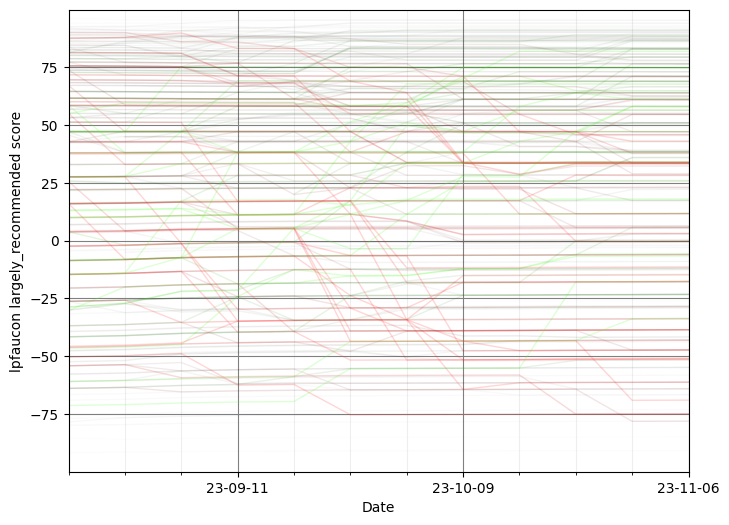

In [8]:
## Video score over time (part 2)
print('Plotting...', end='\r', flush=True)

# Prepare plot
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
# ax.set_ylabel('Collective largely_recommended score')
ax.set_ylabel('lpfaucon largely_recommended score')
ax.set_xlabel('Date')

ax.grid(visible=True, which='major', axis='both', color='gray')
ax.grid(visible=True, which='minor', axis='both', color='#eee')

ax.set_ylim([-100, 100])
ax.yaxis.set_ticks([-75,-50,-25,0,25,50,75])

ax.set_xlim(xmin=DATE_MAP['2023-08-21'], xmax=SORTED_DATES[-1][1])
ax.xaxis.set_ticks([SORTED_DATES[i][1] for i in range(len(SORTED_DATES)-1, 0, -4) if SORTED_DATES[i][0] >= '2023-08-21'])
ax.xaxis.set_ticks([s[1] for s in SORTED_DATES if s[0] >= '2023-08-21'], minor=True)
ax.xaxis.set_major_formatter(mtdt.DateFormatter('%y-%m-%d'))
#ax.set_xlim([0, max_usrs+1])
# ax.set_xscale('log')
# ax.set_xlim([1, 10**math.ceil(math.log(max_usrs,10))])
# ax.xaxis.set_major_formatter(ScalarFormatter())

# Plot lines
n=0
for (n,vid) in enumerate(vid_date_vals):
	# vid_date_vals[vid][date] = (users,vid_cmps,score)
	xx = []
	yy = []
	oo = 0
	for d in sorted(vid_date_vals[vid].keys()):
		data = vid_date_vals[vid][d] #(users,vid_cmps,score)
		if d < '2023-08-21': continue
		xx.append(DATE_MAP[d])
		yy.append(data[2])
		oo = data[0]
	oo = math.sqrt(oo) / math.sqrt(max_usrs)

	#if max(yy)-min(yy) >= 30:
	print(f"Plotting {n+1}/{len(vid_date_vals)}...   ", end='\r', flush=True)
	
	rgbcolor = colorsys.hsv_to_rgb(0 if yy[-1] < yy[0] else 0.3, 0.8, min(1,(max(yy)-min(yy))/25))
	hexcolor = "".join("%02X" % round(i*255) for i in rgbcolor)
	ax.plot_date(xx, yy, linewidth=1, fmt='-', color="#" + hexcolor + hexcolor[-2:]) # color='#0261'
		#if xx[-1] > 18:
		#ax.text(xx[-1], yy[-1], s=YTDATA.videos.get(vid,vid), horizontalalignment='left', verticalalignment='center', fontsize=6)
print()

In [9]:
dateranks:list[list[tuple[float,str]]] = [[],[]] # dateranks[0/1][#rank] = (score,vid)

date0 = '2023-09-25'
date1 = '2023-10-02'

vids:dict[str,set[str]] = dict() # vids[vid] = users
def extractVids(line:ComparisonLine):
	if line.criterion == 'largely_recommended':
		vids.setdefault(line.vid1,set()).add(line.user)
		vids.setdefault(line.vid2,set()).add(line.user)
COMPARISONS[date0].foreach(extractVids)
for vid in list(vids.keys()):
	if len(vids[vid]) < 5:
		vids.pop(vid)

before = COLLECTIVE_SCORES[date0].get_scores(criterion='largely_recommended', vids=vids.keys()) # [vid]['largely_recommended'] = (score,uncertainty)
after = COLLECTIVE_SCORES[date1].get_scores(criterion='largely_recommended', vids=vids.keys())

for vid in vids:
	if vid in before and vid in after:
		dateranks[0].append((before[vid]['largely_recommended'][0], vid))
		dateranks[1].append((after[vid]['largely_recommended'][0], vid))

dateranks[0].sort(reverse=True)
dateranks[1].sort(reverse=True)

ranks:dict[str,tuple[int,int,int]] = dict()
for i,dt0 in enumerate(dateranks[0]):
	ranks[dt0[1]] = (i, None, None)

ordered_ranks = []
for i,dt1 in enumerate(dateranks[1]):
	ranks[dt1[1]] = (ranks[dt1[1]][0], i, i-ranks[dt1[1]][0])
	ordered_ranks.append((abs(ranks[dt1[1]][2]), ranks[dt1[1]][1], dt1[1]))
	#ordered_ranks.append((ranks[dt1[1]][1], dt1[1]))

print(len(ordered_ranks))
ordered_ranks.sort(reverse=True)
print('yt video Id: was (score, uncty), now (score, uncty), rank: before => after : change')
for dt in ordered_ranks:
	vid = dt[-1]
	print(f"{vid}: was {before[vid]['largely_recommended']}, now {after[vid]['largely_recommended']}, rank: {ranks[vid][0]+1} => {ranks[vid][1]+1} : {-ranks[vid][2]:+d}") # {YTDATA.videos.get(dt[1],dt[1])}")




2514
yt video Id: was (score, uncty), now (score, uncty), rank: before => after : change
SxyTn6lhbtg: was (24.03, 56.4), now (34.2, 47.21), rank: 1403 => 686 : +717
cdSnF-6SW8o: was (29.58, 55.72), now (22.06, 59.62), rank: 1014 => 1564 : -550
7Jfz3YBeY9c: was (17.5, 61.46), now (23.99, 57.89), rank: 1912 => 1410 : +502
YdTErpJZ-_4: was (19.03, 57.78), now (25.41, 53.49), rank: 1804 => 1303 : +501
DfFohLBPh2Y: was (24.18, 65.97), now (30.47, 61.18), rank: 1393 => 953 : +440
BgO25FTwfRI: was (23.65, 62.4), now (29.77, 60.15), rank: 1434 => 1004 : +430
WGKIjojADmg: was (25.89, 58.4), now (31.77, 51.65), rank: 1267 => 849 : +418
N3BMx_Wt5Lk: was (20.54, 68.36), now (25.91, 65.04), rank: 1681 => 1272 : +409
ZjBgEkbnX2I: was (29.65, 48.59), now (35.4, 40.78), rank: 1005 => 626 : +379
0CmtDk-joT4: was (29.11, 52.64), now (34.38, 46.37), rank: 1039 => 677 : +362
JvIrKvm5f50: was (24.11, 57.32), now (28.76, 55.19), rank: 1398 => 1069 : +329
R_8sjao6tGI: was (18.31, 68.39), now (22.24, 63.48), 

In [10]:
# Users ranked by how much their scores changed between last 2 weeks

week1_scores = INDIVIDUAL_SCORES[SORTED_DATES[-2][0]].get_scores(criterion='largely_recommended') # [user][vid][crit] = (score, unc.)
vids = {vid for v in week1_scores.values() for vid in v}
week2_scores = INDIVIDUAL_SCORES[SORTED_DATES[-1][0]].get_scores(users=week1_scores.keys(), vids=vids) # [user][vid][crit] = (score, unc.)

users_weekscores: dict[str,list[float]] = dict() # users_weekscores[user] = [upd. score]
for usr in week1_scores:
	if len(week1_scores[usr]) < 10:
		continue
	user_weekscores = list()
	for vid in week1_scores[usr]:
		for crit in week1_scores[usr][vid]:
			if usr in week2_scores and vid in week2_scores[usr] and crit in week2_scores[usr][vid]:
				user_weekscores.append(abs(week2_scores[usr][vid][crit][0]-week1_scores[usr][vid][crit][0]))
	users_weekscores[usr] = user_weekscores

sorted_users = sorted(users_weekscores.keys(), key=lambda usr: sum(users_weekscores[usr]), reverse=True)

print('  user            sum     avg  median    max')
print('---------------  ----  ------  ------  -----')
for user in sorted_users[:10]:
	print(f"{user[:15]:<15}  {sum(users_weekscores[user]):4.0f}  {np.average(users_weekscores[user]):6.2f}  {np.quantile(users_weekscores[user],0.5):6.2f}  {max(users_weekscores[user]):5.1f}")


  user            sum     avg  median    max
---------------  ----  ------  ------  -----
Susmitha         1950   41.49   37.46  113.4
Pierre M          653    0.69    0.03   88.5
samuelnihoul1     647    1.91    0.03   51.2
scayrol           635    1.68    0.01   51.9
ABX               561    1.08    0.02   61.2
thoms             499    4.50    0.07   47.8
Amaresh           472    1.12    0.03  109.5
lpfaucon          321    0.10    0.03   48.8
moltonel          259    7.20    5.68   29.4
Armg              234    1.80    0.03   54.8


In [11]:
"""
ids = ['new', 'w1', 'w2']
steps = [
	# Source / Target / Value / Label / color
	('new', 'w1', .1, '>100', 'rgba(200,0,0,0.25)'),
	('w1', 'w2', .6, '>100', 'rgba(200,0,0,0.25)'),
	('new', 'w2', .1, '>100', 'rgba(200,0,0,0.25)'),
	('new', 'w1', .2, '10-100', 'rgba(150,150,0,0.25)'),
	('w1', 'w2', .8, '10-100', 'rgba(150,150,0,0.25)'),
	('new', 'w2', .2, '10-100', 'rgba(150,150,0,0.25)'),
	('new', 'w1', .1, '<10', 'rgba(100,100,100,0.25)'),
	('w1', 'w2', .2, '<10', 'rgba(100,100,100,0.25)'),
	('new', 'w2', .1, '<10', 'rgba(100,100,100,0.25)')
]
"""
ids = ['<2023-09', 'new']

cmps:dict[str,dict[str,int]] = dict() # [user][date] = nbCmps
def extractCmps(line: ComparisonLine):
	cmps.setdefault(line.user, dict()).setdefault(line.date, 0)
	cmps[line.user][line.date] += 1
COMPARISONS[LAST].foreach(extractCmps)

categories = [('<=10', 'rgba(100,100,100,0.25)'),('10-100', 'rgba(150,150,0,0.25)'), ('>=100', 'rgba(200,0,0,0.25)')]
extracted_data: dict[str,dict[str,list[int]]] = dict() # data[Source][Target] = [<10, 10-100, >100]
for u in cmps:
	prev = 'new'
	for d in sorted(cmps[u]):
		if not d in ids:
			ids.append(d)
		nb = cmps[u][d]
		
		cat = 0
		if nb <= 10:
			pass
		elif nb < 100:
			cat = 1
		else:
			cat = 2

		extracted_data.setdefault(prev, dict()).setdefault(d, [0,0,0])[cat] += 1
		prev = d

steps = [] # (Source, Target, Value, Label, color)
for source in extracted_data:
	for dest in extracted_data[source]:
		if dest < '2023-09':
			continue
		vsource = '<2023-09' if source < '2023-09' else source
		for (cat,count) in enumerate(extracted_data[source][dest]):
			steps.append((vsource, dest, count, categories[cat][0], 'rgba(127,127,127,0.01)' if vsource == '<2023-09' else categories[cat][1]))

steps.sort(key=lambda s:(s[4], s[0], s[1]))

fig = go.Figure(go.Sankey(
	node = dict(
		label=ids,
		pad=10
		# groups=[[0],[1],list(range(2,len(ids)))]
	),
	link = dict(
		source = [ids.index(s[0]) for s in steps],
		target = [ids.index(s[1]) for s in steps],
		value = [s[2] for s in steps],
		label = [s[3] for s in steps],
		color = [s[4] for s in steps],
		# arrowlen=10
	)
))
fig.update_layout(
	autosize=False,
	width=1000,
	height=750
)

In [12]:
"""
ids = ['new', 'w1', 'w2']
steps = [
	# Source / Target / Value / Label / color
	('new', 'w1', .1, '>100', 'rgba(200,0,0,0.25)'),
	('w1', 'w2', .6, '>100', 'rgba(200,0,0,0.25)'),
	('new', 'w2', .1, '>100', 'rgba(200,0,0,0.25)'),
	('new', 'w1', .2, '10-100', 'rgba(150,150,0,0.25)'),
	('w1', 'w2', .8, '10-100', 'rgba(150,150,0,0.25)'),
	('new', 'w2', .2, '10-100', 'rgba(150,150,0,0.25)'),
	('new', 'w1', .1, '<10', 'rgba(100,100,100,0.25)'),
	('w1', 'w2', .2, '<10', 'rgba(100,100,100,0.25)'),
	('new', 'w2', .1, '<10', 'rgba(100,100,100,0.25)')
]
"""
OLD='2023-07'
ids = ['<'+OLD]

cmps:dict[str,dict[str,int]] = dict() # [user][date] = nbCmps
def extractCmps(line: ComparisonLine):
	cmps.setdefault(line.user, dict()).setdefault(line.date, 0)
	cmps[line.user][line.date] += 1
COMPARISONS[LAST].foreach(extractCmps)

categories = [('<=10', 'rgba(100,100,100,0.25)'),('10-100', 'rgba(150,150,0,0.25)'), ('>=100', 'rgba(200,0,0,0.25)')]
extracted_data: dict[str,dict[str,list[int]]] = dict() # data[Source][Target] = [<10, 10-100, >100]
for u in cmps:
	prev = None
	for d in sorted(cmps[u]):
		if not d in ids:
			ids.append(d)
		if prev is None:
			prev = 'new-' + d
			if not prev in ids:
				ids.append(prev)
		elif prev < OLD:
			prev = '<' + OLD
		
		if d > OLD:
			nb = cmps[u][d]
			
			cat = 0
			if nb <= 10:
				pass
			elif nb < 100:
				cat = 1
			else:
				cat = 2

			extracted_data.setdefault(prev, dict()).setdefault(d, [0,0,0])[cat] += 1
		prev = d

steps = [] # (Source, Target, Value, Label, color)
for source in extracted_data:
	for dest in extracted_data[source]:
		for (cat,count) in enumerate(extracted_data[source][dest]):
			steps.append((source, dest, count, categories[cat][0], 'rgba(127,127,127,0)' if source == '<' + OLD else categories[cat][1]))

steps.sort(key=lambda s:(s[4], s[0], s[1]))

fig = go.Figure(go.Sankey(
	node = dict(
		label=ids,
		pad=10
		# groups=[[0],[1],list(range(2,len(ids)))]
	),
	link = dict(
		source = [ids.index(s[0]) for s in steps],
		target = [ids.index(s[1]) for s in steps],
		value = [s[2] for s in steps],
		label = [s[3] for s in steps],
		color = [s[4] for s in steps],
		# arrowlen=10
	)
))
fig.update_layout(
	autosize=False,
	width=1000,
	height=750
)